In [1]:
import train, hparams
import argparse

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-o', '--output_directory', type=str, default='output',
                    help='directory to save checkpoints')
parser.add_argument('-l', '--log_directory', type=str, default='log',
                    help='directory to save tensorboard logs')
parser.add_argument('-c', '--checkpoint_path', type=str, default='output/checkpoint_19000',
                    required=False, help='checkpoint path')
parser.add_argument('--warm_start', action='store_true',
                    help='load model weights only, ignore specified layers')
parser.add_argument('--n_gpus', type=int, default=1,
                    required=False, help='number of gpus')
parser.add_argument('--rank', type=int, default=0,
                    required=False, help='rank of current gpu')
parser.add_argument('--group_name', type=str, default='group_name',
                    required=False, help='Distributed group name')

hparams.add_hparams(parser)
args,_ = parser.parse_known_args()

In [3]:
hparams = hparams.get_hparams(args, parser)

In [4]:
model = train.load_model(hparams)

Namespace(epochs=10000, iters_per_checkpoint=10000, seed=1234, dynamic_loss_scaling=True, fp16_run=False, distributed_run=False, dist_backend='nccl', dist_url='tcp://localhost:54321', cudnn_enabled=True, cudnn_benchmark=False, ignore_layers=['embedding.weight'], load_mel_from_disk=False, training_files='/home/ubuntu/workspace/script.txt', validation_files='/home/ubuntu/workspace/script.txt', text_cleaners=['korean_cleaners'], max_wav_value=32768.0, sampling_rate=22050, filter_length=1024, hop_length=256, win_length=1024, n_mel_channels=80, mel_fmin=0.0, mel_fmax=8000.0, n_symbols=80, symbols_embedding_dim=512, encoder_kernel_size=5, encoder_n_convolutions=3, encoder_embedding_dim=512, n_frames_per_step=1, decoder_rnn_dim=1024, prenet_dim=256, max_decoder_steps=1000, gate_threshold=0.5, p_attention_dropout=0.1, p_decoder_dropout=0.1, attention_rnn_dim=1024, attention_dim=128, attention_location_n_filters=32, attention_location_kernel_size=31, postnet_embedding_dim=512, postnet_kernel_si

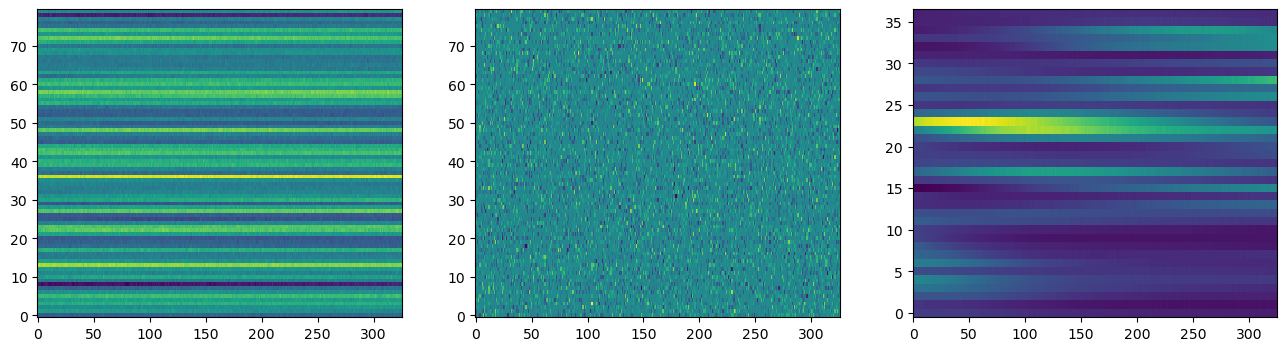

In [5]:
from audio_processing import griffin_lim
from text import text_to_sequence
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none', cmap='viridis')

TEXT = '문장은 하나만 볼 수 있습니다!'
sequence = np.array(text_to_sequence(TEXT, ['korean_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))